In [4]:
#분류의 성능 평가 지표 : 정확도(Accuracy), 오차행렬(Confusion Matrix), 정밀도(Precision), 재현율(Recall), F1스코어, ROC AUC
#분류 => 이진 분류 or 멀티 분류
#1. 정확도(Accuracy) : 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단 => 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    #fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y = None):
        pass
    #predict() 메서드는 단순히 Sex피처가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else :
                pred[i] = 1

        return pred

In [5]:
#피처를 가공한 내역을 정리, 함수로 만들기
#transform_features() : 데이터의 전처리를 전체적으로 호출하는 함수

from sklearn import preprocessing
#Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df

#ML 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
    return df

#레이블 인코딩 수행.
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df


#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv(r'C:\Users\user\Desktop\Python Workspace\titanic\train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size= 0.2, random_state= 0)

#위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행.
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictors = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictors)))
#단순한 알고리즘으로 예측해도 78.77% 
#정확도는 불균형한 레이블 값 분포에서 ML모델의 성능 판단 X

Dummy Classifier의 정확도는: 0.7877


In [7]:
#MNIST 데이터 셋: 0~9까지의 숫자 이미지의 픽셀 정보를 가지고 이를 기반으로 숫자 Digit을 예측하는데 사용 => 멀티 레이블 분류를 위한 것
#레이블 값이 7 => True / 나머지 값은 False => 전체 데이터의 10%만 True, 나머지 90%는 False
#모든 데이터를 0으로 예측하는 classifier를 이용해 정확도 측정 => 90%

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass

    #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros( (len(X), 1), dtype=bool)

#사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state= 11)

In [8]:
#y_test의 데이터 분포도 확인/MyFakeClassifier를 이용해 예측과 평가 수행

#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이브 0과 1 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이브 0과 1 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


In [9]:
## 2. 오차행렬 ##
#오차행렬 : 이진 분류에서 성능 지표로 잘 활용, 이진 분류의 예측 오류가 얼마인지&어떠한 유형의 예측 오류가 발생하고 있는지
#TN, FP, FN, TP => Ex. TN : 예측값을 Negative값 0으로 예측했고 실제 값 역시 Negative 값 0
#confusion_matrix() : 사이킷런에서의 오차 행렬을 구하는 API
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)
#TN: 405, FP : 0, FN : 45, TP : 0

#결론 : 불균형한 데이터 셋에서는 정확도만으로 판단X

array([[405,   0],
       [ 45,   0]], dtype=int64)

In [10]:
#정밀도 : 예측을 Positive로 한 대상 중 예측과 실제 값이 Positive로 일치한 데이터의 비율 => TP/(FP + TP)
#재현율 : 실제 값이 Positive인 대상 중 예측과 실제 값이 Positive로 일치한 데이터의 비율 => TP/(FN + TP)(민감도)
#재현율이 중요한 순간 : 실제 Positive 양성 데이터를 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
#정밀도가 중요한 순간 : 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되는 경우

#precision_score() : 사이킷런에서의 정밀도 계산
#recall_score() : 사이킷런에서의 재현율 계산

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도:{1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))

In [11]:
#로지스틱 회귀 기반으로 타이타닉 생존자 예측

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#데이터 가공, 학습 데이터/테스트 데이터 분할
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis= 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size= 0.20, random_state= 11)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도:0.7742, 재현율: 0.7869


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
#정밀도/재현율 트레이드오프 => 임곗값(threshold)을 조정 => 어느 한쪽을 높이면 다른 하나는 떨어짐
#Ex. 임곗값을 0.5 => 이보다 크면 Positive / 이보다 작으면 Negative
#predict_proba() : 개별 데이터별로 예측확률 반환

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출\n:', pred_proba[:3])

#예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis = 1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출
: [[0.46184057 0.53815943]
 [0.87866995 0.12133005]
 [0.87716959 0.12283041]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46184057 0.53815943 1.        ]
 [0.87866995 0.12133005 0.        ]
 [0.87716959 0.12283041 0.        ]]


In [13]:
#로직을 직접 코드로 구현하면서 정밀도/재현율 트레이드오프 방식을 이해
#predict() : predic_proba()가 반환하는 확률 값에서 정햬진 임곗값을 만족하는 값을 최종 예측 클래스로 결정

#threshold 변수를 특정 값으로 설정 => Binarizer 클래스를 객체로 생성
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

#X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold= 1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [14]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임곗값임
custom_threshold = 0.5

#predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)
#로지스틱 회귀 Classifier객체에서 호출된 predict()로 계산된 지표값과 정확히 동일 => predict()가 predict_proba()에 기반

오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도:0.7742, 재현율: 0.7869


In [15]:
#Binarizer의 threshold 설정값을 0.4로 설정 => 임곗값을 0.5 -> 0.4
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)
#임곗값을 낮춤 => True가 많아짐(Positive로 예측할 확률이 높아짐) => 재현율 Up, 정밀도 Down

오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도:0.7183, 재현율: 0.8361


In [16]:
#임곗값을 0.4 ~ 0.6까지 0.05씩 증가시키며 평가 지표 조사

#테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thrsholds list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1) 
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도:0.7183, 재현율: 0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도:0.7656, 재현율: 0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도:0.7742, 재현율: 0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도:0.8364, 재현율: 0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도:0.8824, 재현율: 0.7377


In [17]:
#precision_recall_curve() : 임곗값 변화에 따른 평가 지표값 알아보기 (y_test:실제 클래스값 배열, probas_pred : Positive칼럼의 예측 확률 배열)
#일반적으로 0.11 ~ 0.95정도의 임곗값을 담은 ndarray와 해당하는 정밀도/재현율 반환

#샘플로 10건만 추출, 임곗값을 15 단계로 추출
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

#반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출, 임곗값을 15 Step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

#15 Step 단위로 추출된 임곗값에 따른 정밀도와 재현율값
print('샘플 임곗값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임곗값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임곗값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임곗값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임곗값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


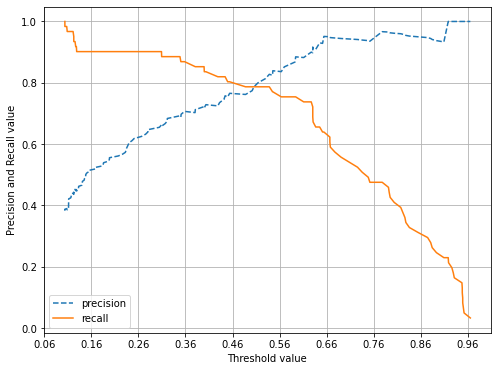

In [18]:
#임곗값 변화에 따른 정밀도/재현율 변화를 곡선 형태로 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    #X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:thresholds_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:thresholds_boundary], label = 'recall')

    #threshold 값 X축의 Scale을 0.1 단위로 변경 
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    #x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel("Threshold value"); plt.ylabel("Precision and Recall value")
    plt.legend(); plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [19]:
##F1 스코어 : 정밀도와 재현율을 결합한 지표 => 어느 한쪽으로 치우치지 않을때 높은 값
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어 : {0:.4f}'.format(f1))

F1 스코어 : 0.7805


In [20]:
#임곗값을 변화시키면서 f1스코어를 포함한 평가 지표 구하기
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    #F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    #f1 score print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}'.format(accuracy, precision, recall, f1))

thresholds  = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값: 0.4
오차 행렬
[[98 20]
 [10 51]]
정확도 : 0.8324, 정밀도 : 0.7183, 재현율 : 0.8361, F1 : 0.7727
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492, 정밀도 : 0.7656, 재현율 : 0.8033, F1 : 0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492, 정밀도 : 0.7742, 재현율 : 0.7869, F1 : 0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659, 정밀도 : 0.8364, 재현율 : 0.7541, F1 : 0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771, 정밀도 : 0.8824, 재현율 : 0.7377, F1 : 0.8036


In [21]:
## ROC 곡선 : FPR이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선(FPR : X축, TPR : Y축)
#TPR : 재현율(민감도) = 실제값 Positive(양성)가 정확히 예측돼야 하는 수준
#TNR : 특이도 = 실제값 Negative(음성)가 정확히 예측돼야 하는 수준
#FPR  = 1 - 특이도

from sklearn.metrics import roc_curve

#레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
#반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출.
#thresholds[0]은 max(예측확률) + 1 로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

#5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(fprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플 index로 추출한 임곗값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임곗값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임곗값별 TPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]


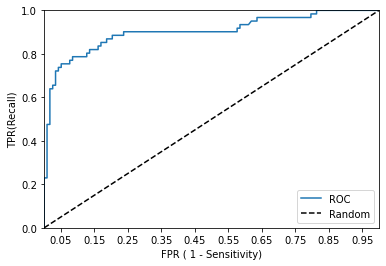

In [22]:
#FPR의 변화에 따른 TPR의 변화를 ROC 곡선으로 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    #임곗값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    #ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label = 'ROC')
    #가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label = 'Random')

    #FPR X축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR ( 1 - Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

In [23]:
#AUC : ROC곡선 밑의 면적값 -> 1에 가까워질수록 좋음
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.9024


In [24]:
#get_clf_eval() 함수에 ROC AUC값을 측정하는 로직을 추가
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    #ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    #ROC-AUC print추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))